In [ ]:
import pandas as pd
import glob
import os
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
#dictionary to store each location dataframe, filename will be the identifier
dataframes = {}

file_paths = glob.glob("*.csv")


for file_path in file_paths:
 #location identifier
    #print("Found CSV file", file_path)
    location = os.path.basename(file_path).replace('.csv', '')
    #print(location)
    columns=['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind']
    #load dataset
    df = pd.read_csv(file_path, names=columns)
    #convert year month day hour to datetime to facilitate timeseries analysis
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)
    df.drop(['Year', 'Month', 'Day', 'Hour'], axis=1, inplace = True)
    #df.head()


    dataframes[location] = df
#print(dataframes)



In [ ]:
#temperature
fig=go.Figure()

for location, df in dataframes.items():
    fig.add_trace(
        go.Scattergl(x=df.index,
                   y=df['Temperature'],
                   mode='lines',
                   opacity=0.5,
                   name=location,
                   line=dict(width=2))
    )

#set the layout
fig.update_layout(title='Temperature over Time',
                  xaxis_title='Time',
                  yaxis_title='Temperature')
#fig.show()
fig.write_html("temperature.html")

In [ ]:
#precipitation graph
fig=go.Figure()

for location, df in dataframes.items():
    fig.add_trace(
        go.Scattergl(x=df.index,
                   y=df['Precipitation'],
                   mode='lines',
                   name=location)
    )

#set the layout
fig.update_layout(title='Precipitation over time',
                  xaxis_title='Time',
                  yaxis_title='Precipitation')
#fig.show()
fig.write_html("precipitation.html")

In [ ]:
#u-wind
fig=go.Figure()

for location, df in dataframes.items():
    fig.add_trace(
        go.Scattergl(x=df.index,
                   y=df['U-wind'],
                   mode='lines',
                   name=location)
    )

#set the layout
fig.update_layout(title='U-wind over time',
                  xaxis_title='Time',
                  yaxis_title='U-wind')
#fig.show()
fig.write_html("uwind.html")

In [ ]:
#v-wind
fig=go.Figure()

for location, df in dataframes.items():
    fig.add_trace(
        go.Scattergl(x=df.index,
                   y=df['V-wind'],
                   mode='lines',
                   name=location)
    )

#set the layout
fig.update_layout(title='V-wind over time',
                  xaxis_title='Time',
                  yaxis_title='V-wind')
#fig.show()
fig.write_html("vwind.html")

Avg monthly temperature and comparison between pairs

In [ ]:
import pandas as pd
import glob
import numpy as np
import os
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
#dictionary to store each location dataframe, filename will be the identifier
dataframes = {}

file_paths = glob.glob("*.csv")


for file_path in file_paths:
 #location identifier
    location = os.path.basename(file_path).replace('.csv', '')
    #print(location)
    columns=['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind']
    #load dataset
    df = pd.read_csv(file_path, names=columns)
    #convert year month day hour to datetime to facilitate timeseries analysis
    df['Temperature'] = df['Temperature'] - 273.15
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)
    df.drop(['Year', 'Month', 'Day', 'Hour'], axis=1, inplace = True)
    #df.head()
    dataframes[location] = df
    #resample by month to take monthly averages
    monthly_avg = df['Temperature'].resample('ME').mean()
    #print(monthly_avg)
    #convert to a datagrame with column name AvgTemp
    monthly_avg_df = monthly_avg.to_frame(name='AvgTemp')
    df['Time_Variable'] = np.arange(len(df.index))
    #store in dictionary with key=location+monthly_avg
    dataframes[location+ '_monthly_avg'] = monthly_avg_df

#max_temps_by_month = {}
#min_temps_by_month = {}

fig = go.Figure()
for location, df in dataframes.items():
    if location.endswith('_monthly_avg'):


 #        max_temps_by_month[location] = df.loc[df.groupby(df.index)['AvgTemp'].idxmax()]
 #        min_temps_by_month[location] = df.loc[df.groupby(df.index)['AvgTemp'].idxmin()]

         fig.add_trace(
            go.Scattergl(
                x=df.index,
                y=df['AvgTemp'],
                mode='lines',
                name=location
            )
        )

#set the layout
fig.update_layout(title='Average Temperature over Time ',
                  xaxis_title='Time',
                  yaxis_title='Average Temperature')
#fig.show()
fig.write_html("avg_temperature.html")




#print(model.summary())
pairs_to_compare = [('CapeTown_SouthAfrica', 'Sydney_Australia'), ('Churchill_Canada', 'Oslo_Norway'), ('Calgary_Canada', 'London_UK'), ('NewYork_USA', 'Rome_Italy'),
                    ('Toronto_Canada', 'Marseille_France'), ('Hyderabad_India','Kingston_Jamaica')]

# Initialize a figure with subplots - adjust rows and cols based on the number of pairs
fig = make_subplots(rows=len(pairs_to_compare),cols=1, subplot_titles=[f'{a} vs {b}' for a, b in pairs_to_compare])
#initialize histogram plot
fig_hist = make_subplots(rows=len(pairs_to_compare), cols=1, subplot_titles=[f'{a} vs {b}' for a,b in pairs_to_compare])

for i, (loc_a, loc_b) in enumerate(pairs_to_compare, start=1):
    # Assuming '_monthly_avg' is appended to the key for the monthly average DataFrame
    df_a = dataframes[loc_a + '_monthly_avg']
    df_b = dataframes[loc_b + '_monthly_avg']
    correlation_coefficient = df_a['AvgTemp'].corr(df_b['AvgTemp'],method='spearman')
    df_a_mean = df_a['AvgTemp'].mean()
    df_b_mean = df_b['AvgTemp'].mean()
    df_a_std = df_a['AvgTemp'].std()
    df_b_std = df_b['AvgTemp'].std()
#kolmogorov smirnov test for normality
    _, p_valuea = stats.kstest(df_a['AvgTemp'], 'norm', args=(df_a_mean,df_a_std))
    _, p_valueb = stats.kstest(df_b['AvgTemp'], 'norm', args=(df_b_mean,df_a_std))

    _, wilcoxon_pvalue = stats.wilcoxon(df_a['AvgTemp'], df_b['AvgTemp'])
    print(f"P value of {loc_a} & {loc_b} after Wilcoxon {wilcoxon_pvalue}")
    print(f"The Spearman Rank Correlation coefficient between {loc_a} & {loc_b} is {correlation_coefficient}\n")
    #print(f"{loc_a} KS Test p_value: {p_valuea}")
    #print(f"{loc_b} KS Test p_value: {p_valueb}")

    # Add traces for each dataset in the pair
    fig.add_trace(
        go.Scatter(x=df_a.index, y=df_a['AvgTemp'], mode='lines', name=f'{loc_a} Avg Temp'),
        row=i, col=1

    )
    fig.add_trace(
        go.Scatter(x=df_b.index, y=df_b['AvgTemp'], mode='lines', name=f'{loc_b} Avg Temp'),
        row=i, col=1
    )
    fig_hist.add_trace(
        go.Box(y=df_a['AvgTemp'], name=f'{loc_a} Avg Temp Hist',  opacity = 0.75),
        row=i, col=1
        )
    fig_hist.add_trace(
        go.Box(y=df_b['AvgTemp'], name=f'{loc_b} Avg Temp Hist', opacity=0.5),
        row=i, col=1
        )
# Update layout if necessary
fig.update_layout(height=400*len(pairs_to_compare), title_text="Comparative Analysis of Average Temperatures")
fig_hist.update_layout(height=400*len(pairs_to_compare), title_text="Comparative Analysis of Average Temperatures - Boxplots",
                       barmode='overlay')
fig.write_html("comparative_average_temperatures.html")
fig_hist.write_html("comparative_average_temperatures_boxplots.html")

P value of CapeTown_SouthAfrica & Sydney_Australia after Mann whitney 4.1141667369842216e-50

The Spearman Rank Correlation coefficient between CapeTown_SouthAfrica & Sydney_Australia is 0.7323662413630133



P value of Churchill_Canada & Oslo_Norway after Mann whitney 3.166747977899348e-78

The Spearman Rank Correlation coefficient between Churchill_Canada & Oslo_Norway is 0.9238987545740717



P value of Calgary_Canada & London_UK after Mann whitney 3.540711785665735e-45

The Spearman Rank Correlation coefficient between Calgary_Canada & London_UK is 0.817528120509999



P value of NewYork_USA & Rome_Italy after Mann whitney 2.7675951521527125e-78

The Spearman Rank Correlation coefficient between NewYork_USA & Rome_Italy is 0.9308675812878568



P value of Toronto_Canada & Marseille_France after Mann whitney 3.9130395423461796e-78

The Spearman Rank Correlation coefficient between Toronto_Canada & Marseille_France is 0.9155945102124269



P value of Hyderabad_India & Kingston_Jamaic

Avg precipitation

In [ ]:
import pandas as pd
import glob
import numpy as np
import os
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import statsmodels.api as sm
#dictionary to store each location dataframe, filename will be the identifier
dataframes = {}

file_paths = glob.glob("*.csv")
for file_path in file_paths:
 #location identifier
    #print("Found CSV file", file_path)
    location = os.path.basename(file_path).replace('.csv', '')
    #print(location)
    columns=['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind']
    #load dataset
    df = pd.read_csv(file_path, names=columns)
    #convert year month day hour to datetime to facilitate timeseries analysis
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)
    df.drop(['Year', 'Month', 'Day', 'Hour'], axis=1, inplace = True)
    #df.head()

    dataframes[location] = df
    #resample by month to take monthly averages
    monthly_avg = df['Precipitation'].resample('ME').mean()
    #print(monthly_avg)
    #convert to a datagrame with column name AvgTemp
    monthly_avg_df = monthly_avg.to_frame(name='AvgPrec')
    #store in dictionary with key=location+monthly_avg
    dataframes[location+ '_monthly_avg'] = monthly_avg_df
    fig = go.Figure()
    for location, df in dataframes.items():
     if location.endswith('_monthly_avg'):
        fig.add_trace(
            go.Scattergl(
                x=df.index,
                y=df['AvgPrec'],
                mode='lines',
                name=location,
                opacity=0.9
            )
        )
fig.update_layout(title='Average Precipitation over Time',
                  xaxis_title='Time',
                  yaxis_title='Average Precipitation')
#fig.show()
fig.write_html("avg_precipitation.html")

Avg yearly temperature


In [ ]:
import pandas as pd
import glob
import numpy as np
import os
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import statsmodels.api as sm
#dictionary to store each location dataframe, filename will be the identifier
dataframes = {}

file_paths = glob.glob("*.csv")


for file_path in file_paths:
 #location identifier
    #print("Found CSV file", file_path)
    location = os.path.basename(file_path).replace('.csv', '')
    #print(location)
    columns=['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind']
    #load dataset
    df = pd.read_csv(file_path, names=columns)
    #convert year month day hour to datetime to facilitate timeseries analysis
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)
    df.drop(['Year', 'Month', 'Day', 'Hour'], axis=1, inplace = True)
    #df.head()

    dataframes[location] = df
    #resample by month to take monthly averages
    yearly_avg = df['Temperature'].resample('YE').mean()
    #print(yearly_avg)
    #convert to a datagrame with column name YearlyTemp
    yearly_avg_df = yearly_avg.to_frame(name='YearlyTemp')
    #print(monthly_avg_df)
    #print(dataframes)
    #store in dictionary with key=location+yearly avg
    dataframes[location+ '_yearly_avg'] = yearly_avg_df
fig = go.Figure()
for location, df in dataframes.items():
    if location.endswith('_yearly_avg'):
         df['Time_Variable'] = np.arange(len(df))
         fig.add_trace(
            go.Scattergl(
                x=df.index,
                y=df['YearlyTemp'],
                mode='lines',
                name=location
            )
        )
   #      fig.add_trace(
   #          go.Scattergl(
   #              x=df.index,
   #              y=df['Fitted'],
   #              mode='lines',
   #              name=location
   #          )
   #      )
#set the layout
fig.update_layout(title='Average Temperature over Time with Regression Fit',
                  xaxis_title='Time',
                  yaxis_title='Average Temperature')
#fig.show()
fig.write_html("avg_yearly_temperature.html")

Yearly precipitation

In [ ]:
import pandas as pd
import glob
import numpy as np
import os
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import statsmodels.api as sm
#dictionary to store each location dataframe, filename will be the identifier
dataframes = {}

file_paths = glob.glob("*.csv")


for file_path in file_paths:
 #location identifier
    #print("Found CSV file", file_path)
    location = os.path.basename(file_path).replace('.csv', '')
    #print(location)
    columns=['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind']
    #load dataset
    df = pd.read_csv(file_path, names=columns)
    #convert year month day hour to datetime to facilitate timeseries analysis
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)
    df.drop(['Year', 'Month', 'Day', 'Hour'], axis=1, inplace = True)
    #df.head()

    dataframes[location] = df
    #resample by month to take monthly averages
    yearly_avg = df['Precipitation'].resample('YE').mean()
    #print(monthly_avg)
    #convert to a datagrame with column name AvgPrec
    yearly_avg_df = yearly_avg.to_frame(name='AvgPrec')
    #print(monthly_avg_df)
    #print(dataframes)
    #store in dictionary with key=location+monthly_avg
    dataframes[location+ '_yearly_avg'] = yearly_avg_df
    fig = go.Figure()
    for location, df in dataframes.items():
     if location.endswith('_yearly_avg'):
        fig.add_trace(
            go.Scattergl(
                x=df.index,
                y=df['AvgPrec'],
                mode='lines',
                name=location,
                opacity=0.9
            )
        )
fig.update_layout(title='Average Precipitation over Time',
                  xaxis_title='Time',
                  yaxis_title='Average Precipitation')
#fig.show()
fig.write_html("avg_yearly_precipitation.html")

#minimum and maximum avg temperature

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import glob

# Update this glob pattern if your files are in a different directory
file_paths = glob.glob("*.csv")  # Update the path accordingly

# Prepare the figure for plotting; adjust rows and cols as per your requirement
rows = len(file_paths)  # Assuming each file gets a row for max and min temp plots
cols = 1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[os.path.basename(fp).replace('.csv', '') for fp in file_paths])

for index, file_path in enumerate(file_paths):
    # Extract the location name from the file path
    location = os.path.basename(file_path).split('.')[0]  # Assumes name is before the '.csv'

    # Load the dataset
    columns = ['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind']
    df = pd.read_csv(file_path, names=columns, header=None, skiprows=1)
    df['Temperature'] = df['Temperature'] - 273.15
    # Convert to appropriate datetime format
    #create a datetime column and set it as index
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)

    monthly_avg_temp = df.resample('ME')['Temperature'].mean()
    # Resample to monthly max and min temperatures
    monthly_max = df.resample('ME')['Temperature'].max()
    monthly_min = df.resample('ME')['Temperature'].min()

    # Add max temperature scatter plot
    fig.add_trace(go.Scatter(x=monthly_max.index, y=monthly_max, mode='lines+markers', name=f'Max Temp {location}'), row=index+1, col=1)

    # Add min temperature scatter plot
    fig.add_trace(go.Scatter(x=monthly_min.index, y=monthly_min, mode='lines+markers', name=f'Min Temp {location}'), row=index+1, col=1)

# Update layout for a clear view
fig.update_layout(height=3000, width=800, title_text="Max and Min Monthly Temperatures Across Locations")
fig.write_html("min_max_temperature.html")

maxima and minima lines with avg temperature plots

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import glob
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
import numpy as np
# Define your CSV file paths (adjust the path as necessary)
file_paths = glob.glob("*.csv")  # Update with the actual path to your files

# Prepare subplots
fig = make_subplots(rows=len(file_paths), cols=1, subplot_titles=[os.path.basename(fp).split('.')[0] for fp in file_paths])

for index, file_path in enumerate(file_paths):
    # Extract location from the file name
    location = os.path.basename(file_path).split('.')[0]

    # Load the dataset
    columns = ['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind']
    df = pd.read_csv(file_path, names=columns, header=None, skiprows=1)

    # Convert temperature to Celsius (assuming it's in Kelvin)
    df['Temperature'] = df['Temperature'] - 273.15

    # Create datetime index
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)

    # Calculate monthly average temperatures
    monthly_avg_temp = df.resample('ME')['Temperature'].mean().reset_index()

    # Plot monthly averages for this location
    fig.add_trace(go.Scatter(x=monthly_avg_temp['Datetime'], y=monthly_avg_temp['Temperature'], mode='lines+markers', name=f'{location} Avg Temp'), row=index+1, col=1)

    #datetime converted to numeric year for regression analysis
    monthly_avg_temp['Year'] = monthly_avg_temp['Datetime'].dt.year + monthly_avg_temp['Datetime'].dt.month / 12

    #local maxima
    peaks, _ = find_peaks(monthly_avg_temp['Temperature'], prominence = 2.2, distance=6, width=3)
    maxima = monthly_avg_temp.iloc[peaks]

    peaks, _ = find_peaks(-monthly_avg_temp['Temperature'], prominence = 2.2, distance=6, width=3)
    minima = monthly_avg_temp.iloc[peaks]
    #dates_for_plotting = pd.to_datetime(pd.DataFrame(X_fit, columns=['Year']).astype(int), format='%Y')
    # Calculate and plot annual min/max from monthly averages
    #max_monthly_avg = monthly_avg_temp['Temperature'].max()
    #min_monthly_avg = monthly_avg_temp['Temperature'].min()
    #convert datetime to a numeric format (years since start)
    monthly_avg_temp['YearNumeric'] = (monthly_avg_temp['Datetime'] - monthly_avg_temp['Datetime'].min()).dt.total_seconds() / (365.25 * 24 * 60 * 60)

    #prepare dataset for regression
    X_max = monthly_avg_temp.loc[maxima.index,'YearNumeric'].values.reshape(-1,1)
    y_max = maxima['Temperature'].values

    X_min = monthly_avg_temp.loc[minima.index,'YearNumeric'].values.reshape(-1,1)
    y_min = minima['Temperature'].values

    #fit regression models
    reg_max = LinearRegression().fit(X_max,y_max)
    reg_min = LinearRegression().fit(X_min,y_min)

    #get slope and intercept
    slope_max, intercept_max = reg_max.coef_[0], reg_max.intercept_
    slope_min, intercept_min = reg_min.coef_[0], reg_min.intercept_
    print(f"{location} Minima trend: slope = {slope_min}, Maxima trend slope= {slope_max}")


    #predict values for plotting the regression line
    X_fit = np.linspace(X_max.min(),X_max.max(),100).reshape(-1,1)

    #prepare a range of x values for the trend lines
    X_range = pd.date_range(start=monthly_avg_temp['Datetime'].min(), end=monthly_avg_temp['Datetime'].max(), periods = 100)
    X_range_numeric = (X_range - monthly_avg_temp['Datetime'].min()).total_seconds() /  (365.25 * 24 * 60 * 60)
    #predict y values for trend lines

    y_max_fit = reg_max.predict(X_fit)
    y_min_fit = reg_min.predict(X_fit)
    fig.add_trace(go.Scattergl(x=maxima['Datetime'], y=maxima['Temperature'], mode='lines+markers', name=f'{location} Maxima'), row=index+1, col=1)
    fig.add_trace(go.Scattergl(x=minima['Datetime'], y=minima['Temperature'], mode='lines+markers', name=f'{location} Minima'), row=index+1, col=1)
    #prepare results for linear regressions
    #prepare results for linear regressions
'''
    X_max = maxima['Year'].values.reshape(-1,1)
    y_max = maxima['Temperature'].values


    X_min = minima['Year'].values.reshape(-1,1)
    y_min = minima['Temperature'].values

    reg_max = LinearRegression().fit(X_max,y_max)
    reg_min = LinearRegression().fit(X_min,y_min)

    #interpret results
    slope_max = reg_max.coef_[0]
    intercept_max = reg_max.intercept_
    #print(f"Maxima trend: slope = {slope_max}, intercept = {intercept_max}")

    # For minima
    slope_min = reg_min.coef_[0]
    intercept_min = reg_min.intercept_
    #print(f"Minima trend: slope = {slope_min}, intercept = {intercept_min}")

    #predict values for maxima and minima
    X_fit = np.linspace(X_max.min(), X_max.max(), 100).reshape(-1,1)
    y_max_fit = reg_max.predict(X_fit)
    y_min_fit = reg_min.predict(X_fit)
    print(f"Adding maxima and minima traces for {location} at subplot row {index + 1}")

    # Add regression line traces for maxima and minima to the plotly figure
    fig.add_trace(go.Scatter(x=maxima['Datetime'], y=y_max_fit, mode='lines', name=f'{location} Maxima Line', line=dict(color='red', width=2)), row=index+1, col=1)
    fig.add_trace(go.Scatter(x=minima['Datetime'], y=y_min_fit, mode='lines', name=f' {location} Minima Line', line=dict(color='blue', width=2)), row=index+1, col=1)

    # Print out the slope and intercept for maxima and minima
    print(f"{location} - Maxima slope: {slope_max}, intercept: {intercept_max}")
    print(f"{location} - Minima slope: {slope_min}, intercept: {intercept_min}")

'''
# Update layout for clarity and visibility
fig.update_layout(height=3000, title_text="Monthly Averages and Annual Extremes Across Locations")
fig.write_html("min_max_avg_temperature.html")

CapeTown_SouthAfrica Minima trend: slope = 0.002835585291045642, Maxima trend slope= 0.029993085471890273

NewYork_USA Minima trend: slope = 0.06448292603754979, Maxima trend slope= 0.025568309170446574

Marseille_France Minima trend: slope = 0.011237550786451772, Maxima trend slope= 0.027937338996572206

Hyderabad_India Minima trend: slope = 0.03426890083510024, Maxima trend slope= 0.014346094441443578

Kingston_Jamaica Minima trend: slope = 0.011195362215547611, Maxima trend slope= 0.017713293472625156

Rome_Italy Minima trend: slope = 0.01999224856534878, Maxima trend slope= 0.033542164816756405

Sydney_Australia Minima trend: slope = 0.023611739356318547, Maxima trend slope= 0.004019678340931804

Toronto_Canada Minima trend: slope = 0.02914237205301091, Maxima trend slope= 0.018745858348793325

London_UK Minima trend: slope = 0.022677184700723996, Maxima trend slope= 0.01393157826512865

Calgary_Canada Minima trend: slope = 0.0949737749058798, Maxima trend slope= 0.0075290506378929

find ranges of each month temperatures and create a video

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import os
import glob
import imageio

file_paths = glob.glob("*.csv")
dataframes = {}

# Load and process the data
for file_path in file_paths:
    location = os.path.basename(file_path).split('.')[0]
    df = pd.read_csv(file_path, names=['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind'], header=None, skiprows=1)
    df['Temperature'] = df['Temperature'] - 273.15  # Convert from Kelvin to Celsius
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)

    # Resample and calculate range
    df_monthly = df.resample('ME').agg({'Temperature': ['max', 'min']})
    df_monthly['Range'] = df_monthly[('Temperature', 'max')] - df_monthly[('Temperature', 'min')]
    dataframes[location] = df_monthly

# Directory for saving images
image_dir = "images"
os.makedirs(image_dir, exist_ok=True)

# Identify all unique months across all locations to ensure plotting for every month
all_months = []
for df_monthly in dataframes.values():
    all_months.extend(df_monthly.index.strftime('%Y-%m').unique())
all_months = sorted(set(all_months))

for current_month in all_months:
    fig = go.Figure()

    for location, df_monthly in dataframes.items():
        # Filter the dataframe for the current month
        df_filtered = df_monthly[df_monthly.index.strftime('%Y-%m') == current_month]
        if not df_filtered.empty:
            fig.add_trace(go.Bar(
                y=[location],
                x=df_filtered['Range'],
                name=location,
                orientation = 'h',
            ))

    # Update layout for the current month
    fig.update_layout(
        title=f"Temperature Range Comparison - {current_month}",
        xaxis_title="Temperature Range (°C)",
        yaxis_title="Location",
        barmode='group'
    )
    # Save the figure as an image file for the current month
    fig.write_image(f"{image_dir}/{current_month}.png")

# Compile images into a video
video_path = "video/temperature_ranges_comparison.mp4"
os.makedirs(os.path.dirname(video_path), exist_ok=True)
writer = imageio.get_writer(video_path, fps=5)  # Frames per second

for image_file in sorted(glob.glob(f"{image_dir}/*.png")):
    image = imageio.imread(image_file)
    writer.append_data(image)

writer.close()

#plot the YEARLY ranges and their regression line

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import os
import glob
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression

file_paths = glob.glob("*.csv")  # Update this to the path where your CSV files are located
yearly_dataframes = {}



# Process each file
for file_path in file_paths:
    location = os.path.basename(file_path).split('.')[0]
    df = pd.read_csv(file_path, names=['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U-wind', 'V-wind'], header=None, skiprows=1)
    df['Temperature'] = df['Temperature'] - 273.15  # Convert from Kelvin to Celsius
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    df.set_index('Datetime', inplace=True)

    df_monthly = df.resample('YE').agg({'Temperature': ['max', 'min']})
    df_monthly['Range'] = df_monthly[('Temperature', 'max')] - df_monthly[('Temperature', 'min')]
    yearly_dataframes[location] = df_monthly

# Prepare the figure for plotting; adjust rows and cols as per your requirement
rows = len(file_paths)  # Assuming each file gets a row for max and min temp plots
cols = 1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[os.path.basename(fp).replace('.csv', '') for fp in file_paths])

# Analyze and plot for each location separately
for index, (location, df_monthly) in enumerate(yearly_dataframes.items()):
    df_reset = df_monthly.reset_index()
    start_year = df_reset['Datetime'].min().year
    df_reset['YearsSinceStart'] = df_reset['Datetime'].dt.year - start_year

    X = df_reset[['YearsSinceStart']]
    y = df_reset['Range']

    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)

        # Determine the layout of subplots (trying to make it as square as possible)
    num_locations = len(yearly_dataframes)


    # Print regression results for the current location
    print(f"{location}: Intercept = {model.intercept_:.2f}, Slope = {model.coef_[0]:.2f}")
    # Create a Plotly figure for the current location
    fig.add_trace(go.Scatter(x=df_reset['YearsSinceStart'], y=y, mode='markers', name='Actual Range', marker=dict(size=8)), row=index+1, col = 1)
    fig.add_trace(go.Scatter(x=df_reset['YearsSinceStart'], y=predictions, mode='lines', name='Regression Line'), row=index+1, col=1)
# Update layout for the entire figure
fig.update_layout(height=3000, title_text='Yearly Temperature Range Over Time - All Locations')

# Save the figure to a single HTML file
fig.write_html("all_locations_temperature_ranges.html")



CapeTown_SouthAfrica: Intercept = 12.46, Slope = 0.03

NewYork_USA: Intercept = 55.87, Slope = -0.04

Marseille_France: Intercept = 20.57, Slope = 0.01

Hyderabad_India: Intercept = 33.12, Slope = 0.02

Kingston_Jamaica: Intercept = 8.89, Slope = -0.00

Rome_Italy: Intercept = 22.91, Slope = 0.02

Sydney_Australia: Intercept = 36.90, Slope = 0.04

Toronto_Canada: Intercept = 54.92, Slope = -0.05

London_UK: Intercept = 16.22, Slope = -0.02

Calgary_Canada: Intercept = 66.17, Slope = -0.03

Churchill_Canada: Intercept = 73.02, Slope = -0.04

Oslo_Norway: Intercept = 47.12, Slope = -0.14


Seasonal ARIMA model for temp prediction

<Figure size 640x480 with 0 Axes>

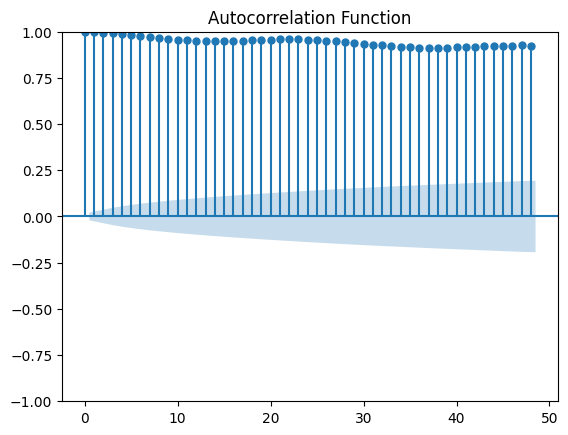

<Figure size 640x480 with 0 Axes>

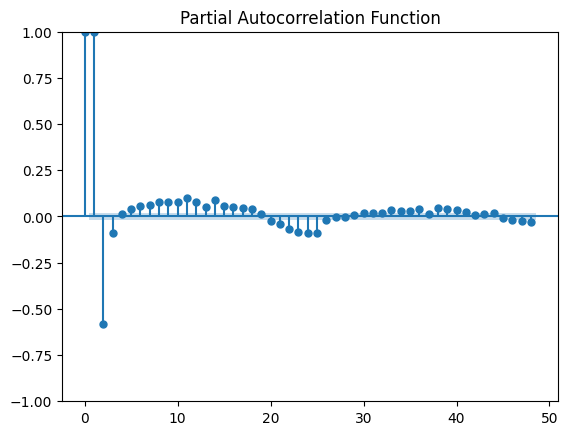

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
import glob
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller


#dictionary to store each location dataframe, filename will be the identifier
file_paths = glob.glob("*.csv")

# Define column names since the dataset does not include them
columns = ['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U_wind', 'V_wind']
df = pd.read_csv('Rome_Italy.csv', names=columns)
#convert kelvin to celcius
df['Temperature'] = df['Temperature'] - 273.15

first_year = df['Temperature'].head(24 * 7 * 52)
#check stationarity using Augmented Dickey-Fuller test (if p < 0.05 then stationary o/w difference the data)
#p_value = adfuller(df['Temperature'], autolag='AIC')
#print(f"P value: {p_value[1]}")





#24 lags to cover daily seasonality
lags = 24
#ACF #ACF shows the correlation of the series with its own lagged values,
plt.figure()
plot_acf(first_year, lags=48)
plt.title('Autocorrelation Function')


#plot PACF
plt.figure()
plot_pacf(first_year, lags=48, method='ywm')
plt.title('Partial Autocorrelation Function')

plt.show()
# Example SARIMA parameters
#p and seasonal P (num of autoregressive terms)
#d and seasonal D (indicate differencing that must be done to stationarize series)
#q and seasonal Q (indicate number of moving average terms (lags of the foregast error))
#s indicates seasonal length in the data
p, d, q = 1, 1, 2  # Non-seasonal parameters
P, D, Q, s = 1, 1, 2, 24  # Seasonal parameters (assuming daily seasonality)

#add split point, train , test and fit sarimax model
# Split the dataset into training and testing sets
#split_index = int(len(df) * 0.8)
#train_data = df['Temperature'][:split_index]
#test_data = df['Temperature'][split_index:]

first_year_df = first_year.to_frame()
split_index = int(len(first_year_df) * 0.8)
train_data = first_year_df[:split_index]
test_data = first_year_df[split_index:]

model = SARIMAX(train_data, order=(p,d,q), seasonal_order = (P,D,Q,s))
model_fit = model.fit()
  #make predictions
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

mse = mean_squared_error(test_data, predictions)

rmse = sqrt(mse)

print(f"MSE:  {mse}")
print(f"RMSE: {rmse}")

plt.figure()
plt.plot(test_data, label='Real Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()


LSTM with train_test split (non cyclical features min max scaling)
train_test_split used

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow as tf; tf.keras
from keras import Sequential, optimizers
from keras.layers import Dense, BatchNormalization, Input, LSTM, Dropout
import plotly.graph_objects as go
import gc
from keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader, Dataset

#dictionary to store each location dataframe, filename will be the identifier
file_paths = glob.glob("*.csv")

# Define column names since the dataset does not include them
columns = ['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U_wind', 'V_wind']

df = pd.read_csv('Rome_Italy.csv', names=columns)
df = df.tail(24 * 7 * 52 * 1)
#combine date and time into a single column
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['hourofday'] = df['Datetime'].dt.hour
#get dates
dates = df['Datetime']
#convert kelvin to celcius
df['Temperature'] = df['Temperature'] - 273.15  # Convert from Kelvin to Celsius
#convert to cyclical features and normalise
df['day_sin'] = np.sin(df['dayofyear'] * (2 * np.pi / 365)) #cyclical day sin
df['day_cos'] = np.cos(df['dayofyear'] * (2 * np.pi / 365)) #cyclical day cos
df['hour_sin'] = np.sin(df['hourofday'] * (2 * np.pi / 24)) #sin of hour of the day
df['hour_cos'] = np.cos(df['hourofday'] * (2 * np.pi / 24)) #cos of hour of the day
#drop original year, month, day, hour and datetime columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Datetime', 'dayofyear', 'hourofday'], axis=1)
#get the 7 features including
features = df[['Precipitation','U_wind', 'V_wind']]
cyclic_features = df[['day_sin', 'day_cos', 'hour_sin', 'hour_cos']]
#input_shape = (features.shape[1],)
#print(input_shape)
target = df['Temperature']
#gc.collect() #pythons garbage collections
#print(features.shape, target.shape)
#scaling the features to ensure that all variables contribute to model's training process
#MinMaxScaler is used to scale all features and targets to a range of [0,1]
#feature_range=(0,1) by default
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)
scaled_features = np.concatenate([scaled_features, cyclic_features], axis=1)

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target.values.reshape(-1,1))
#append scaled features with cyclic ones
#scaled_features = np.concatenate([scaled_features, cyclic_features], axis=1)
#print(scaled_features.shape[1],)
# Define sequence and forecast length
sequence_length = 7 * 24 #30 days as hourly data
forecast_length = 7 * 24 # 7 days

#function createss a sequence of sequence length and the next forecast_length as the target output
#input of size of no_features (7)
def create_sequences(input_data, target_data, sequence_length, forecast_length):
    sequences = []
    targets = []
    indices = []
    for i in range(len(input_data) - sequence_length - forecast_length + 1):
      #slice of input data starting from i and ending at i+seq_length
        sequences.append(input_data[i : (i + sequence_length)])
      #slice of target data starting from i+seq_length and ends at i+seq+forecast
        targets.append(target_data[(i + sequence_length) : (i + sequence_length + forecast_length)])
      #calculate index of last element
        indices.append(i + sequence_length + forecast_length - 1)
    return np.array(sequences), np.array(targets), np.array(indices)

#create sequences and targets to use for train and test
X, y, indices = create_sequences(scaled_features,scaled_target, sequence_length, forecast_length)
start_index = indices[-1] - forecast_length + 1
predicted_datetimes = dates[start_index : start_index + forecast_length]
#gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#return_sequences=True
# LSTM(32, activation='relu'),
#droput = randomly sents inputs units to 0 with the set frequency rate at each step during training time
#helps prevent overfitting
model = Sequential([
    LSTM(100,return_sequences=True, input_shape=(sequence_length, scaled_features.shape[1])),
    Dropout(0.1),
    LSTM(100,return_sequences=True),
    Dropout(0.1),
    LSTM(100, return_sequences=False),
    Dropout(0.1),
    Dense(forecast_length)
])
#mae (mean absolute error- avg magnitude of errors)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', min_delta= 0.0001, patience=6, verbose=1, mode='min')
#fit model on training with 20% validation on training data
history = model.fit(X_train, y_train, epochs=25, validation_split=0.1, callbacks=[early_stopping], batch_size=32, verbose=1) #callbacks = [early_stopping, reduce_lr]
#model evaluation on unseen data

test_loss, test_metric = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_metric}")

'''
The MAE gives you a more realistic estimate of the average error,
but it might not reflect the severity of the worst errors
from sklearn.metrics import mean_squared_error
'''
last_sequence =   X_test[-1].reshape((1, sequence_length, scaled_features.shape[1]))
predicted_temp = model.predict(last_sequence)
actual_temp = y_test[-1]

predicted_temperature_values = scaler_target.inverse_transform(predicted_temp.reshape(-1,1))
actual_temperature = scaler_target.inverse_transform(actual_temp.reshape(-1,1))
#print(f"Predicted temperatures: {predicted_temperature_values}")
#print(f"Actual temperatures: {actual_temperature}")
#actual_temp = actual_temp.flatten()
#predicted_temp = predicted_temp.flatten()

#root mean squared error for predictions
rmse = np.sqrt(mean_squared_error(actual_temperature, predicted_temperature_values))
#mean absolute error for predictions
mae = mean_absolute_error(actual_temperature, predicted_temperature_values)
#mean absolute percentage error (mape), provides an intuitive measure of prediction acc
mape = np.mean(np.abs((actual_temperature - predicted_temperature_values) / actual_temp)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

fig=go.Figure()

fig.add_trace(go.Scattergl(
    x=predicted_datetimes,
    y=actual_temperature.flatten(), mode='lines', name='Actual Temps'
))

fig.add_trace(go.Scattergl(
    x=predicted_datetimes,
    y=predicted_temperature_values.flatten(), mode='lines', name='Predicted Temps'
))
fig.update_layout(title='Predictions vs Actual Values',
                  xaxis_title='Date',
                  yaxis_title='Temperature')
fig.show()



Epoch 1/25
189/189 [==============================] - 13s 34ms/step - loss: 0.0317 - mae: 0.1149 - val_loss: 0.0042 - val_mae: 0.0492
Epoch 2/25
189/189 [==============================] - 4s 21ms/step - loss: 0.0071 - mae: 0.0659 - val_loss: 0.0041 - val_mae: 0.0483
Epoch 3/25
189/189 [==============================] - 4s 23ms/step - loss: 0.0059 - mae: 0.0600 - val_loss: 0.0040 - val_mae: 0.0474
Epoch 4/25
189/189 [==============================] - 5s 24ms/step - loss: 0.0053 - mae: 0.0565 - val_loss: 0.0037 - val_mae: 0.0445
Epoch 5/25
189/189 [==============================] - 5s 28ms/step - loss: 0.0048 - mae: 0.0539 - val_loss: 0.0039 - val_mae: 0.0435
Epoch 6/25
189/189 [==============================] - 7s 40ms/step - loss: 0.0046 - mae: 0.0522 - val_loss: 0.0036 - val_mae: 0.0457
Epoch 7/25
189/189 [==============================] - 5s 29ms/step - loss: 0.0044 - mae: 0.0512 - val_loss: 0.0036 - val_mae: 0.0429
Epoch 8/25
189/189 [==============================] - 5s 26ms/step -

scaling of non cyclic features + target (-1,1) - 1 week prediction

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow as tf; tf.keras
from keras import Sequential, optimizers
from keras.layers import Dense, BatchNormalization, Input, LSTM, Dropout, Bidirectional
from keras.regularizers import l2
import plotly.graph_objects as go
import gc
from keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader, Dataset

#dictionary to store each location dataframe, filename will be the identifier
file_paths = glob.glob("*.csv")

# Define column names since the dataset does not include them
columns = ['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U_wind', 'V_wind']

df = pd.read_csv('Rome_Italy.csv', names=columns)
df = df.tail(24 * 7 * 52 * 1)
#combine date and time into a single column
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['hourofday'] = df['Datetime'].dt.hour
#get dates
dates = df['Datetime']
#convert kelvin to celcius
df['Temperature'] = df['Temperature'] - 273.15  # Convert from Kelvin to Celsius
#convert to cyclical features and normalise
df['day_sin'] = np.sin(df['dayofyear'] * (2 * np.pi / 365)) #cyclical day sin
df['day_cos'] = np.cos(df['dayofyear'] * (2 * np.pi / 365)) #cyclical day cos
df['hour_sin'] = np.sin(df['hourofday'] * (2 * np.pi / 24)) #sin of hour of the day
df['hour_cos'] = np.cos(df['hourofday'] * (2 * np.pi / 24)) #cos of hour of the day
#drop original year, month, day, hour and datetime columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Datetime', 'dayofyear', 'hourofday'], axis=1)
#get the 7 features including
features = df[['Precipitation','U_wind', 'V_wind', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']]
cyclic_features = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos']
non_cyclic_features =  ['Precipitation', 'U_wind', 'V_wind']
#input_shape = (features.shape[1],)
#print(input_shape)
target = ['Temperature']

#split point for train and test
train_split_point = int(len(df) * 0.7)
val_split_point = int(len(df) * 0.85)
train_df = df.iloc[:train_split_point]
val_df = df.iloc[train_split_point:val_split_point]
test_df = df.iloc[val_split_point:]
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
#intializa minmaxscaler
scaler_features = MinMaxScaler(feature_range = (-1,1))
scaler_target = MinMaxScaler(feature_range = (-1,1))
#scale features
train_features_scaled = scaler_features.fit_transform(train_df[non_cyclic_features])
val_features_scaled = scaler_features.transform(val_df[non_cyclic_features])
test_features_scaled = scaler_features.transform(test_df[non_cyclic_features])
#scale targets
train_target_scaled = scaler_target.fit_transform(train_df[target])
val_target_scaled = scaler_target.transform(val_df[target])
test_target_scaled = scaler_target.transform(test_df[target])


#scaled features back to dataframe
train_features_scaled = pd.DataFrame(train_features_scaled, columns=non_cyclic_features, index=train_df.index)
val_features_scaled = pd.DataFrame(val_features_scaled, columns=non_cyclic_features,index=val_df.index)
test_features_scaled = pd.DataFrame(test_features_scaled, columns=non_cyclic_features, index=test_df.index)


#add cyclic features back
train_features_final = pd.concat([train_features_scaled, train_df[cyclic_features]], axis=1)
val_features_final = pd.concat([val_features_scaled, val_df[cyclic_features]], axis=1)
test_features_final = pd.concat([test_features_scaled, test_df[cyclic_features]], axis=1)

#sequence length and forecast length
sequence_length = 30  * 24
forecast_length = 7 * 24
#prepare time series for training
#create 2 empty lists, one for sequences (length=sequence length)
#one for target data (length = forecast_length)
def create_sequences(input_data, target_data, sequence_length, forecast_length):
  sequences  = []
  targets = []
  # = []
  #for loop from zero to len(input_data) - sequence_length 0 forecast_length +1
  for i in range(len(input_data) - sequence_length - forecast_length + 1):
    sequences.append(input_data[i:(i+sequence_length)])
    targets.append(target_data[(i+sequence_length):(i+sequence_length + forecast_length)])
  #  indices.append(i + sequence_length + forecast_length - 1)
  return np.array(sequences), np.array(targets)

#lstm model, 3 layers
model = Sequential([
    Input(shape=(sequence_length, train_features_final.shape[1])),
    LSTM(124,return_sequences=True),
    Dropout(0.20),
    LSTM(124,return_sequences=True),
    Dropout(0.20),
    LSTM(124, return_sequences=False),
    Dropout(0.20),
    Dense(forecast_length)
])



model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

#create sequences for training,validation and testing
X_train, y_train = create_sequences(train_features_final.values, train_target_scaled.flatten(), sequence_length, forecast_length)
X_val, y_val = create_sequences(val_features_final.values, val_target_scaled.flatten(), sequence_length, forecast_length)
X_test, y_test = create_sequences(test_features_final.values, test_target_scaled.flatten(), sequence_length, forecast_length)



early_stopping = EarlyStopping(monitor='loss', min_delta= 0.0001, patience=3, verbose=1, mode='min')
history = model.fit(X_train, y_train, epochs=20,validation_split=0.20,  callbacks=[early_stopping], batch_size=124, verbose=1)

#model evaluation on unseen data
test_loss, test_metric = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_metric}")



#get last sequence to predict it
last_sequence = test_features_final.values[-sequence_length:].reshape(1, sequence_length, -1)
predicted_temperature_scaled = model.predict(last_sequence, verbose=1)
#rescale back to original scale
predicted_temperature = scaler_target.inverse_transform(predicted_temperature_scaled.reshape(-1,1))
#get actual temperature values
actual_temperature_scaled = test_target_scaled[-forecast_length:]
actual_temperature = scaler_target.inverse_transform(actual_temperature_scaled.reshape(-1,1))

# Extract the dates for the last sequence
last_sequence_dates = dates.values[-forecast_length:]
print(actual_temperature.shape)
print(predicted_temperature.shape)

#root mean squared error for predictions
rmse = np.sqrt(mean_squared_error(actual_temperature, predicted_temperature))
#mean absolute error for predictions
mae = mean_absolute_error(actual_temperature, predicted_temperature)
#mean absolute percentage error (mape), provides an intuitive measure of prediction acc
mape = np.mean(np.abs((actual_temperature - predicted_temperature) / actual_temperature)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

fig=go.Figure()

fig.add_trace(go.Scattergl(
    x=last_sequence_dates,
    y=actual_temperature.flatten(), mode='lines', name='Actual Temps'
))

fig.add_trace(go.Scattergl(
    x=last_sequence_dates,
    y=predicted_temperature.flatten(), mode='lines', name='Predicted Temps'
))
fig.update_layout(title='Predictions vs. Actual Values',
                  xaxis_title='Date',
                  yaxis_title='Temperature', width=800, height=600)
fig.show()

(6115, 8)
(1310, 8)
(1311, 8)
Epoch 1/20
34/34 [==============================] - 13s 176ms/step - loss: 0.1070 - mae: 0.2416 - val_loss: 0.0061 - val_mae: 0.0633
Epoch 2/20
34/34 [==============================] - 5s 138ms/step - loss: 0.0170 - mae: 0.1021 - val_loss: 0.0047 - val_mae: 0.0590
Epoch 3/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0125 - mae: 0.0879 - val_loss: 0.0039 - val_mae: 0.0542
Epoch 4/20
34/34 [==============================] - 5s 145ms/step - loss: 0.0107 - mae: 0.0812 - val_loss: 0.0044 - val_mae: 0.0580
Epoch 5/20
34/34 [==============================] - 5s 140ms/step - loss: 0.0097 - mae: 0.0773 - val_loss: 0.0036 - val_mae: 0.0514
Epoch 6/20
34/34 [==============================] - 5s 146ms/step - loss: 0.0087 - mae: 0.0734 - val_loss: 0.0033 - val_mae: 0.0466
Epoch 7/20
34/34 [==============================] - 5s 142ms/step - loss: 0.0081 - mae: 0.0707 - val_loss: 0.0037 - val_mae: 0.0471
Epoch 8/20
34/34 [===========================

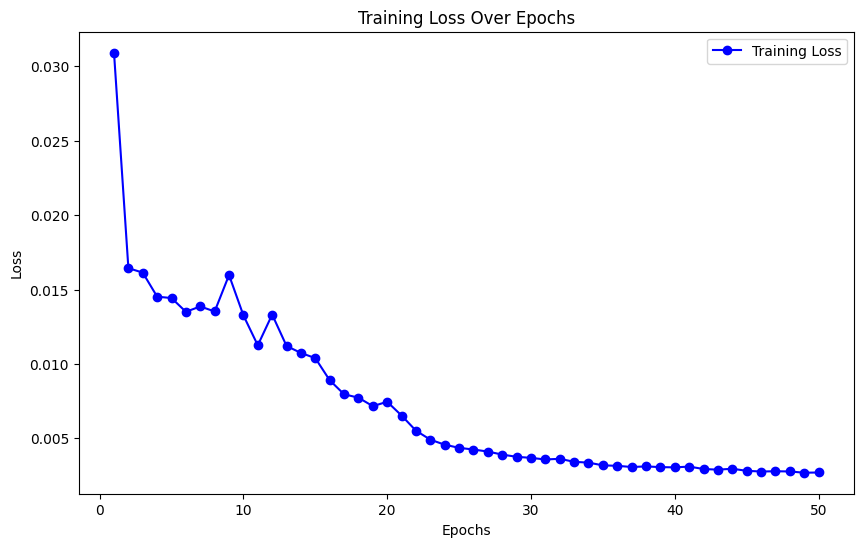

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model.fit() method
training_loss = history.history['loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

non-cyclical features + target (-1,1) scaling - 1 day pred

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow as tf; tf.keras
from keras import Sequential, optimizers
from keras.layers import Dense, BatchNormalization, Input, LSTM, Dropout, Bidirectional
from keras.regularizers import l2
import plotly.graph_objects as go
import gc
from keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader, Dataset
from keras.callbacks import ReduceLROnPlateau


#dictionary to store each location dataframe, filename will be the identifier
file_paths = glob.glob("*.csv")

# Define column names since the dataset does not include them
columns = ['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U_wind', 'V_wind']

df = pd.read_csv('Rome_Italy.csv', names=columns)
df = df.tail(24 * 7 * 52 * 1)
#combine date and time into a single column
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['hourofday'] = df['Datetime'].dt.hour
#get dates
dates = df['Datetime']
#convert kelvin to celcius
df['Temperature'] = df['Temperature'] - 273.15  # Convert from Kelvin to Celsius
#convert to cyclical features and normalise
df['day_sin'] = np.sin(df['dayofyear'] * (2 * np.pi / 365)) #cyclical day sin
df['day_cos'] = np.cos(df['dayofyear'] * (2 * np.pi / 365)) #cyclical day cos
df['hour_sin'] = np.sin(df['hourofday'] * (2 * np.pi / 24)) #sin of hour of the day
df['hour_cos'] = np.cos(df['hourofday'] * (2 * np.pi / 24)) #cos of hour of the day
#drop original year, month, day, hour and datetime columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Datetime', 'dayofyear', 'hourofday'], axis=1)
#get the 7 features including
features = df[['Precipitation','U_wind', 'V_wind', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']]
cyclic_features = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos']
non_cyclic_features =  ['Precipitation', 'U_wind', 'V_wind']
#input_shape = (features.shape[1],)
#print(input_shape)
target = ['Temperature']

#split point for train and test
train_split_point = int(len(df) * 0.7)
val_split_point = int(len(df) * 0.85)
train_df = df.iloc[:train_split_point]
val_df = df.iloc[train_split_point:val_split_point]
test_df = df.iloc[val_split_point:]
#print(train_df.shape)
#print(val_df.shape)
#print(test_df.shape)
#intializa minmaxscaler
scaler_features = MinMaxScaler(feature_range = (-1,1))
scaler_target = MinMaxScaler(feature_range = (-1,1))
#scale features
train_features_scaled = scaler_features.fit_transform(train_df[non_cyclic_features])
val_features_scaled = scaler_features.transform(val_df[non_cyclic_features])
test_features_scaled = scaler_features.transform(test_df[non_cyclic_features])
#scale targets
train_target_scaled = scaler_target.fit_transform(train_df[target])
val_target_scaled = scaler_target.transform(val_df[target])
test_target_scaled = scaler_target.transform(test_df[target])


#scaled features back to dataframe
train_features_scaled = pd.DataFrame(train_features_scaled, columns=non_cyclic_features, index=train_df.index)
val_features_scaled = pd.DataFrame(val_features_scaled, columns=non_cyclic_features,index=val_df.index)
test_features_scaled = pd.DataFrame(test_features_scaled, columns=non_cyclic_features, index=test_df.index)


#add cyclic features back
train_features_final = pd.concat([train_features_scaled, train_df[cyclic_features]], axis=1)
val_features_final = pd.concat([val_features_scaled, val_df[cyclic_features]], axis=1)
test_features_final = pd.concat([test_features_scaled, test_df[cyclic_features]], axis=1)

#sequence length and forecast length
sequence_length = 7  * 24
forecast_length = 1 * 24

def create_sequences(input_data, target_data, sequence_length, forecast_length):
  sequences  = []
  targets = []
  # = []
  for i in range(len(input_data) - sequence_length - forecast_length + 1):
    sequences.append(input_data[i:(i+sequence_length)])
    targets.append(target_data[(i+sequence_length):(i+sequence_length + forecast_length)])
  #  indices.append(i + sequence_length + forecast_length - 1)
  return np.array(sequences), np.array(targets)

#lstm model, 3 layers
model = Sequential([
    Input(shape=(sequence_length, train_features_final.shape[1])),
    LSTM(100,return_sequences=True),
    Dropout(0.20),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(forecast_length)
])



model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

#create sequences for training,validation and testing
X_train, y_train = create_sequences(train_features_final.values, train_target_scaled.flatten(), sequence_length, forecast_length)
X_val, y_val = create_sequences(val_features_final.values, val_target_scaled.flatten(), sequence_length, forecast_length)
X_test, y_test = create_sequences(test_features_final.values, test_target_scaled.flatten(), sequence_length, forecast_length)

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='mae', min_delta= 0.001, patience=10, verbose=1, mode='min')
history = model.fit(X_train, y_train, epochs=40,validation_split=0.2,  callbacks=[early_stopping], batch_size=124, verbose=1)

#model evaluation on unseen data
test_loss, test_metric = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_metric}")


#get last sequence to predict it
last_sequence = test_features_final.values[-sequence_length:].reshape(1, sequence_length, -1)
predicted_temperature_scaled = model.predict(last_sequence, verbose=1)
#rescale back to original scale
predicted_temperature = scaler_target.inverse_transform(predicted_temperature_scaled.reshape(-1,1))
#get actual temperature values
actual_temperature_scaled = test_target_scaled[-forecast_length:]
actual_temperature = scaler_target.inverse_transform(actual_temperature_scaled.reshape(-1,1))

# Extract the dates for the last sequence
last_sequence_dates = dates.values[-forecast_length:]
print(actual_temperature.shape)
print(predicted_temperature.shape)

#root mean squared error for predictions
rmse = np.sqrt(mean_squared_error(actual_temperature, predicted_temperature))
#mean absolute error for predictions
mae = mean_absolute_error(actual_temperature, predicted_temperature)
#mean absolute percentage error (mape), provides an intuitive measure of prediction acc
mape = np.mean(np.abs((actual_temperature - predicted_temperature) / actual_temperature)) * 100


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

print(f"MAPE: {mape}")

fig=go.Figure()

fig.add_trace(go.Scattergl(
    x=last_sequence_dates,
    y=actual_temperature.flatten(), mode='lines', name='Actual Temps'
))

fig.add_trace(go.Scattergl(
    x=last_sequence_dates,
    y=predicted_temperature.flatten(), mode='lines', name='Predicted Temps'
))
fig.update_layout(title='Predictions vs. Actual Values',
                  xaxis_title='Date',
                  yaxis_title='Temperature', width=800, height=600)
fig.show()


Epoch 1/40
39/39 [==============================] - 12s 85ms/step - loss: 0.0408 - mae: 0.1441 - val_loss: 0.0145 - val_mae: 0.1030
Epoch 2/40
39/39 [==============================] - 1s 33ms/step - loss: 0.0154 - mae: 0.0929 - val_loss: 0.0176 - val_mae: 0.1162
Epoch 3/40
39/39 [==============================] - 1s 33ms/step - loss: 0.0130 - mae: 0.0851 - val_loss: 0.0169 - val_mae: 0.1045
Epoch 4/40
39/39 [==============================] - 1s 33ms/step - loss: 0.0121 - mae: 0.0823 - val_loss: 0.0222 - val_mae: 0.1090
Epoch 5/40
39/39 [==============================] - 1s 33ms/step - loss: 0.0110 - mae: 0.0794 - val_loss: 0.0154 - val_mae: 0.0948
Epoch 6/40
39/39 [==============================] - 1s 34ms/step - loss: 0.0107 - mae: 0.0785 - val_loss: 0.0143 - val_mae: 0.0913
Epoch 7/40
39/39 [==============================] - 1s 33ms/step - loss: 0.0099 - mae: 0.0759 - val_loss: 0.0127 - val_mae: 0.0954
Epoch 8/40
39/39 [==============================] - 1s 34ms/step - loss: 0.0093 - 

all features min max scaling (-1,1) - 1 day pred

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow as tf; tf.keras
from keras import Sequential, optimizers
from keras.layers import Dense, BatchNormalization, Input, LSTM, Dropout, Bidirectional
import plotly.graph_objects as go
import gc
from keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader, Dataset

#dictionary to store each location dataframe, filename will be the identifier
file_paths = glob.glob("*.csv")

# Define column names since the dataset does not include them
columns = ['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Precipitation', 'U_wind', 'V_wind']

df = pd.read_csv('Rome_Italy.csv', names=columns)
df = df.tail(24 * 7 * 52 * 1)
#combine date and time into a single column
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['hourofday'] = df['Datetime'].dt.hour
#get dates
dates = df['Datetime']
#convert kelvin to celcius
df['Temperature'] = df['Temperature'] - 273.15  # Convert from Kelvin to Celsius
#convert to cyclical features and normalise
df['day_sin'] = np.sin(df['dayofyear'] * (2 * np.pi / 365)) #cyclical day sin
df['day_cos'] = np.cos(df['dayofyear'] * (2 * np.pi / 365)) #cyclical day cos
df['hour_sin'] = np.sin(df['hourofday'] * (2 * np.pi / 24)) #sin of hour of the day
df['hour_cos'] = np.cos(df['hourofday'] * (2 * np.pi / 24)) #cos of hour of the day
#drop original year, month, day, hour and datetime columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Datetime', 'dayofyear', 'hourofday'], axis=1)
#get the 7 features including
features = ['Precipitation','U_wind', 'V_wind', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']
#input_shape = (features.shape[1],)
#print(input_shape)
target = ['Temperature']

#split point for train and test
train_split_point = int(len(df) * 0.7)
val_split_point = int(len(df) * 0.85)
train_df = df.iloc[:train_split_point]
val_df = df.iloc[train_split_point:val_split_point]
test_df = df.iloc[val_split_point:]
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
#intializa minmaxscaler
scaler_features = MinMaxScaler(feature_range=(-1, 1))
#scaler_target = MinMaxScaler(feature_range=(-1, 1))
#scale features
train_features_scaled = scaler_features.fit_transform(train_df[features])
val_features_scaled = scaler_features.transform(val_df[features])
test_features_scaled = scaler_features.transform(test_df[features])
#scale targets
#train_target_scaled = scaler_target.fit_transform(train_df[target])
#val_target_scaled = scaler_target.transform(val_df[target])
#test_target_scaled = scaler_target.transform(test_df[target])
train_target_scaled = train_df[target]
val_target_scaled = val_df[target]
test_target_scaled = test_df[target]

#scaled features back to dataframe
train_features_final = pd.DataFrame(train_features_scaled, columns=features, index=train_df.index)
val_features_final = pd.DataFrame(val_features_scaled, columns=features,index=val_df.index)
test_features_final = pd.DataFrame(test_features_scaled, columns=features, index=test_df.index)


#add cyclic features back
#train_features_final = pd.concat([train_features_scaled, train_df[cyclic_features]], axis=1)
#val_features_final = pd.concat([val_features_scaled, val_df[cyclic_features]], axis=1)
#test_features_final = pd.concat([test_features_scaled, test_df[cyclic_features]], axis=1)

#sequence length and forecast length
sequence_length =  7 * 24
forecast_length = 1 * 24

def create_sequences(input_data, target_data, sequence_length, forecast_length):
  sequences  = []
  targets = []
  # indices = []
  for i in range(len(input_data) - sequence_length - forecast_length + 1):
    sequences.append(input_data[i:(i+sequence_length)])
    targets.append(target_data[(i+sequence_length):(i+sequence_length + forecast_length)])
  #  indices.append(i + sequence_length + forecast_length - 1)
  return np.array(sequences), np.array(targets)


model = Sequential([
    Input(shape=(sequence_length, train_features_final.shape[1])),
    LSTM(100,return_sequences=True),
    Dropout(0.15),
    LSTM(100,return_sequences=True),
    Dropout(0.15),
    LSTM(100, return_sequences=False),
    Dropout(0.15),
    Dense(forecast_length)
])


model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

X_train, y_train = create_sequences(train_features_final.values, train_target_scaled, sequence_length, forecast_length)
X_val, y_val = create_sequences(val_features_final.values, val_target_scaled, sequence_length, forecast_length)
X_test, y_test = create_sequences(test_features_final.values, test_target_scaled, sequence_length, forecast_length)

early_stopping = EarlyStopping(monitor='loss', min_delta= 0.0001, patience=15, verbose=1, mode='min')
history = model.fit(X_train, y_train, epochs=40,  callbacks=[early_stopping], batch_size=64, verbose=1)
print(X_val.shape)
print(y_val.shape)
#model evaluation on unseen data
test_loss, test_metric = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_metric}")


#get last sequence to predict it
last_sequence = test_features_final.values[-sequence_length:].reshape(1, sequence_length, -1)
#predicted_temperature_scaled = model.predict(last_sequence)
predicted_temperature = model.predict(last_sequence)
predicted_temperature = predicted_temperature.reshape(-1,1)
#rescale back to original scale
#predicted_temperature = scaler_target.inverse_transform(predicted_temperature_scaled.reshape(-1,1))
#get actual temperature values
#actual_temperature_scaled = test_target_scaled[-forecast_length:]
actual_temperature = test_target_scaled[-forecast_length:]
#actual_temperature = scaler_target.inverse_transform(actual_temperature_scaled.reshape(-1,1))
actual_temperature = actual_temperature.to_numpy().flatten()
# Extract the dates for the last sequence
last_sequence_dates = dates.values[-forecast_length:]
print(actual_temperature.shape)
print(predicted_temperature.shape)
#actual_temperature = actual_temperature.to_numpy()
#predicted_temperature = predicted_temperature.to_numpy()
#root mean squared error for predictions

rmse = np.sqrt(mean_squared_error(actual_temperature, predicted_temperature))
#mean absolute error for predictions
mae = mean_absolute_error(actual_temperature, predicted_temperature)
#mean absolute percentage error (mape), provides an intuitive measure of prediction acc
mape = np.mean(np.abs((actual_temperature - predicted_temperature) / actual_temperature)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
fig=go.Figure()

fig.add_trace(go.Scattergl(
    x=last_sequence_dates,
    y=actual_temperature.flatten(), mode='lines', name='Actual Temps'
))

fig.add_trace(go.Scattergl(
    x=last_sequence_dates,
    y=predicted_temperature.flatten(), mode='lines', name='Predicted Temps'
))
fig.update_layout(title='Predictions vs. Actual Values',
                  xaxis_title='Date',
                  yaxis_title='Temperature')
fig.show()


(6115, 8)
(1310, 8)
(1311, 8)
Epoch 1/40
93/93 [==============================] - 10s 23ms/step - loss: 195.4234 - mae: 12.3034
Epoch 2/40
93/93 [==============================] - 2s 27ms/step - loss: 59.5258 - mae: 6.3152
Epoch 3/40
93/93 [==============================] - 2s 21ms/step - loss: 38.3234 - mae: 5.3597
Epoch 4/40
93/93 [==============================] - 2s 21ms/step - loss: 36.5670 - mae: 5.2959
Epoch 5/40
93/93 [==============================] - 2s 21ms/step - loss: 36.1429 - mae: 5.2597
Epoch 6/40
93/93 [==============================] - 2s 21ms/step - loss: 36.5527 - mae: 5.2943
Epoch 7/40
93/93 [==============================] - 2s 21ms/step - loss: 36.3427 - mae: 5.2787
Epoch 8/40
93/93 [==============================] - 3s 27ms/step - loss: 36.5188 - mae: 5.2971
Epoch 9/40
93/93 [==============================] - 2s 21ms/step - loss: 36.1565 - mae: 5.2664
Epoch 10/40
93/93 [==============================] - 2s 21ms/step - loss: 36.2668 - mae: 5.2798
Epoch 11/40
93/9

In [ ]:
import os
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

TPU not found
